###### Content under Creative Commons Attribution license CC-BY 4.0, code under BSD 3-Clause License © 2018  by D. Koehn, notebook style sheet by L.A. Barba, N.C. Clementi

In [1]:
# Execute this cell to load the notebook's style sheet, then ignore it
from IPython.core.display import HTML
css_file = '../style/custom.css'
HTML(open(css_file, "r").read())

# Performance optimization of the 2D acoustic finite difference modelling code

During the [last class](http://nbviewer.jupyter.org/github/daniel-koehn/Theory-of-seismic-waves-II/blob/master/05_2D_acoustic_FD_modelling/1_From_1D_to_2D_acoustic_FD_modelling_final.ipynb), it took us only 15 minutes to develop a 2D acoustic FD code based on the 1D code. However, with a runtime of roughly 3 minutes, the performance of this "vanilla" Python implementation was quite underwhelming. Therefore, the aim of this lesson is to optimize the performance of this code. 

Let's start with a slightly modified version of the original code. Basically, I moved the computation of the analytical solution outside the main code, the discretization parameters $nx,\; nz,\; nt,\; dx,\; dz,\; dt$ are also fixed in order to minimize the input to the FD modelling function.

In [2]:
# Import Libraries 
# ----------------
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from pylab import rcParams

# Ignore Warning Messages
# -----------------------
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Definition of modelling parameters
# ----------------------------------
xmax = 500.0 # maximum spatial extension of the 1D model in x-direction (m)
zmax = xmax  # maximum spatial extension of the 1D model in z-direction(m)
dx   = 1.0   # grid point distance in x-direction
dz   = dx    # grid point distance in z-direction

tmax = 0.502   # maximum recording time of the seismogram (s)
dt   = 0.0010  # time step

vp0  = 580.   # P-wave speed in medium (m/s)

# acquisition geometry
xr = 330.0 # x-receiver position (m)
zr = xr    # z-receiver position (m)

xsrc = 250.0 # x-source position (m)
zsrc = 250.0 # z-source position (m)

f0   = 40. # dominant frequency of the source (Hz)
t0   = 4. / f0 # source time shift (s)

In [4]:
# define model discretization
# ---------------------------

nx = (int)(xmax/dx) # number of grid points in x-direction
print('nx = ',nx)

nz = (int)(zmax/dz) # number of grid points in x-direction
print('nz = ',nz)

nt = (int)(tmax/dt) # maximum number of time steps            
print('nt = ',nt)

ir = (int)(xr/dx)      # receiver location in grid in x-direction    
jr = (int)(zr/dz)      # receiver location in grid in z-direction

isrc = (int)(xsrc/dx)  # source location in grid in x-direction
jsrc = (int)(zsrc/dz)  # source location in grid in x-direction

# Source time function (Gaussian)
# -------------------------------
src  = np.zeros(nt + 1)
time = np.linspace(0 * dt, nt * dt, nt)

# 1st derivative of a Gaussian
src  = -2. * (time - t0) * (f0 ** 2) * (np.exp(- (f0 ** 2) * (time - t0) ** 2))

# Analytical solution
# -------------------
G    = time * 0.

# Initialize coordinates
# ----------------------
x    = np.arange(nx)
x    = x * dx       # coordinates in x-direction (m)

z    = np.arange(nz)
z    = z * dz       # coordinates in z-direction (m)

# calculate source-receiver distance
r = np.sqrt((x[ir] - x[isrc])**2 + (z[jr] - z[jsrc])**2)

for it in range(nt): # Calculate Green's function (Heaviside function)
    if (time[it] - r / vp0) >= 0:
        G[it] = 1. / (2 * np.pi * vp0**2) * (1. / np.sqrt(time[it]**2 - (r/vp0)**2))
Gc   = np.convolve(G, src * dt)
Gc   = Gc[0:nt]
lim  = Gc.max() # get limit value from the maximum amplitude

# Initialize model (assume homogeneous model)
# -------------------------------------------
vp    = np.zeros((nx,nz))
vp2    = np.zeros((nx,nz))

vp  = vp + vp0       # initialize wave velocity in model
vp2 = vp**2

nx =  500
nz =  500
nt =  502


In [5]:
# 2D Wave Propagation (Finite Difference Solution) 
# ------------------------------------------------
def FD_2D_acoustic_vanilla():        
    
    # Initialize empty pressure arrays
    # --------------------------------
    p    = np.zeros((nx,nz)) # p at time n (now)
    pold = np.zeros((nx,nz)) # p at time n-1 (past)
    pnew = np.zeros((nx,nz)) # p at time n+1 (present)
    d2px = np.zeros((nx,nz)) # 2nd spatial x-derivative of p
    d2pz = np.zeros((nx,nz)) # 2nd spatial z-derivative of p

    # Initialize empty seismogram
    # ---------------------------
    seis = np.zeros(nt) 
    
    # Calculate Partial Derivatives
    # -----------------------------
    for it in range(nt):
    
        # FD approximation of spatial derivative by 3 point operator
        for i in range(1, nx - 1):
            for j in range(1, nz - 1):
                
                d2px[i,j] = (p[i + 1,j] - 2 * p[i,j] + p[i - 1,j]) / dx ** 2                
                d2pz[i,j] = (p[i,j + 1] - 2 * p[i,j] + p[i,j - 1]) / dz ** 2

        # Time Extrapolation
        # ------------------
        pnew = 2 * p - pold + vp ** 2 * dt ** 2 * (d2px + d2pz)

        # Add Source Term at isrc
        # -----------------------
        # Absolute pressure w.r.t analytical solution
        pnew[isrc,jsrc] = pnew[isrc,jsrc] + src[it] / (dx * dz) * dt ** 2
                
        # Remap Time Levels
        # -----------------
        pold, p = p, pnew
    
        # Output of Seismogram
        # -----------------
        seis[it] = p[ir,jr]

You know what happened the last time, we executed the cell below. We had to wait 4 minutes until the modelling run finished. So for safety reasons I commented the code execution and defined the runtime. You should adapt the value of the timing measurement `t_vanilla_python` by the value of your computer.

In [6]:
#%time FD_2D_acoustic_vanilla()
t_vanilla_python = 239.0

## Just-In-Time (JIT) code compilation with Numba 

The poor performance of the vanilla Python code is due to the nested FOR loops to compute the 2nd spatial FD derivatives. We can optimize the performance using the `Numba ` library  for Python ([http://numba.pydata.org/](http://numba.pydata.org/)) which turns Python functions into C-style compiled functions using [LLVM](https://en.wikipedia.org/wiki/LLVM). A nice introduction to Numba was presented at the SciPy conference 2016 by Gil Forsyth & Lorena Barba with the title 

**Numba: Tell those C++ bullies to get lost**

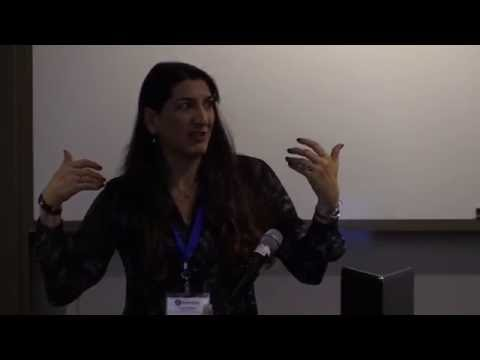

In [7]:
from IPython.display import YouTubeVideo
YouTubeVideo('SzBi3xdEF2Y')

The associated Jupyter notebooks can be cloned from [here](https://github.com/barbagroup/numba_tutorial_scipy2016).

First, we have to install Numba, which is quite easy using Anaconda:

`conda install numba` 

From the Numba library we import **jit**: 

In [8]:
# import JIT from Numba
from numba import jit

The only thing, we modify in our original Python code is to add the function decorator 

`@jit(nopython=True)`

which tags the function `FD_2D_acoustic_JIT` to be compiled:

In [9]:
# FD_2D_acoustic code with JIT optimization
# -----------------------------------------
@jit(nopython=True) # use Just-In-Time (JIT) Compilation for C-performance
def FD_2D_acoustic_JIT():        
    
    # Initialize empty pressure arrays
    # --------------------------------
    p    = np.zeros((nx,nz)) # p at time n (now)
    pold = np.zeros((nx,nz)) # p at time n-1 (past)
    pnew = np.zeros((nx,nz)) # p at time n+1 (present)
    d2px = np.zeros((nx,nz)) # 2nd spatial x-derivative of p
    d2pz = np.zeros((nx,nz)) # 2nd spatial z-derivative of p

    # Initialize empty seismogram
    # ---------------------------
    seis = np.zeros(nt) 
    
    # Calculate Partial Derivatives
    # -----------------------------
    for it in range(nt):
    
        # FD approximation of spatial derivative by 3 point operator
        for i in range(1, nx - 1):
            for j in range(1, nz - 1):
                
                d2px[i,j] = (p[i + 1,j] - 2 * p[i,j] + p[i - 1,j]) / dx**2                
                d2pz[i,j] = (p[i,j + 1] - 2 * p[i,j] + p[i,j - 1]) / dz**2

        # Time Extrapolation
        # ------------------
        pnew = 2 * p - pold + vp2 * dt**2 * (d2px + d2pz)

        # Add Source Term at isrc
        # -----------------------
        # Absolute pressure w.r.t analytical solution
        pnew[isrc,jsrc] = pnew[isrc,jsrc] + src[it] / (dx * dz) * dt ** 2
                
        # Remap Time Levels
        # -----------------
        pold, p = p, pnew
    
        # Output of Seismogram
        # -----------------
        seis[it] = p[ir,jr]   
        
    return seis

Let's run the code:

In [11]:
%time seis_FD_JIT = FD_2D_acoustic_JIT()

CPU times: user 372 ms, sys: 0 ns, total: 372 ms
Wall time: 373 ms


Wow, you don't have to wait 4 minutes, but only 796 ms. Run the cell above again ...

... and you see that the runtime is suddenly further decreased to 372 ms. This performance improvement can be explained by the code compilation during the first run of the code. So by simply using the `@jit` function decorator we get a performance increase of almost **642x** compared to the non-optimized Python code.

Generally, it is a good idea to estimate the performance of a code based on multiple runtime estimations instead of just one. To achieve this replace the magic function `%time` by `%timeit`

In [13]:
%timeit seis_FD_JIT = FD_2D_acoustic_JIT()

# run code again to compute seismogram for JIT compiled Python code
seis_FD_JIT = FD_2D_acoustic_JIT()

349 ms ± 12.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Replace the runtime of the JIT compiled Python code in the cell below by your own runtime measurement

In [14]:
t_JIT_python = 0.349  # runtime of JIT compiled Python code (s)

Another approach to get rid of the nested FOR-loops is to use Numpy array operations:

In [15]:
# FD_2D_acoustic code with NumPy arrays
# -------------------------------------
def FD_2D_acoustic_numpy():        
    
    # Initialize empty pressure arrays
    # --------------------------------
    p    = np.zeros((nx,nz)) # p at time n (now)
    pold = np.zeros((nx,nz)) # p at time n-1 (past)
    pnew = np.zeros((nx,nz)) # p at time n+1 (present)
    d2px = np.zeros((nx,nz)) # 2nd spatial x-derivative of p
    d2pz = np.zeros((nx,nz)) # 2nd spatial z-derivative of p

    # Initialize empty seismogram
    # ---------------------------
    seis = np.zeros(nt) 
    
    # Calculate Partial Derivatives
    # -----------------------------
    for it in range(nt):    

        # Old FD approximation of spatial derivative by 3-point operator
        # using nested FOR-loops is replaced by ...
        #for i in range(1, nx - 1):
        #    for j in range(1, nz - 1):
        #        
        #        d2px[i,j] = (p[i + 1,j] - 2 * p[i,j] + p[i - 1,j]) / dx**2                
        #        d2pz[i,j] = (p[i,j + 1] - 2 * p[i,j] + p[i,j - 1]) / dz**2
        
        # ... Numpy array operations:
        d2px[1:-2,1:-2] = (p[2:-1,1:-2] - 2 * p[1:-2,1:-2] + p[0:-3,1:-2]) / dx**2
        d2pz[1:-2,1:-2] = (p[1:-2,2:-1] - 2 * p[1:-2,1:-2] + p[1:-2,0:-3]) / dz**2
        
        # Time Extrapolation
        # ------------------
        pnew = 2 * p - pold + vp ** 2 * dt ** 2 * (d2px + d2pz)

        # Add Source Term at isrc
        # -----------------------
        # Absolute pressure w.r.t analytical solution
        pnew[isrc,jsrc] = pnew[isrc,jsrc] + src[it] / (dx * dz) * dt ** 2
                
        # Remap Time Levels
        # -----------------
        pold, p = p, pnew
    
        # Output of Seismogram
        # -----------------
        seis[it] = p[ir,jr]   
        
    return seis

In [16]:
%timeit seis_FD_numpy = FD_2D_acoustic_numpy()

# run code again to compute seismogram for Python code with NumPy array operations
seis_FD_numpy = FD_2D_acoustic_numpy()

2 s ± 2.23 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [17]:
t_numpy_python = 2.0  # runtime of JIT compiled Python code (s)

The runtime 2 s of the `NumPy` version is not as fast as the 0.349 s of the JIT version, but a **119x** improvement is still better than the non-optimized version. Can JIT also improve the performance of `FD_2D_acoustic_numpy`?

In [18]:
# FD_2D_acoustic code with NumPy arrays + JIT
# -------------------------------------------
@jit(nopython=True) # use Just-In-Time (JIT) Compilation for C-performance
def FD_2D_acoustic_numpy_JIT():        
    
    # Initialize empty pressure arrays
    # --------------------------------
    p    = np.zeros((nx,nz)) # p at time n (now)
    pold = np.zeros((nx,nz)) # p at time n-1 (past)
    pnew = np.zeros((nx,nz)) # p at time n+1 (present)
    d2px = np.zeros((nx,nz)) # 2nd spatial x-derivative of p
    d2pz = np.zeros((nx,nz)) # 2nd spatial z-derivative of p

    # Initialize empty seismogram
    # ---------------------------
    seis = np.zeros(nt) 
    
    # Calculate Partial Derivatives
    # -----------------------------
    for it in range(nt):    

        # Old FD approximation of spatial derivative by 3-point operator
        # using Numpy array operations
        d2px[1:-2,1:-2] = (p[2:-1,1:-2] - 2 * p[1:-2,1:-2] + p[0:-3,1:-2]) / dx**2
        d2pz[1:-2,1:-2] = (p[1:-2,2:-1] - 2 * p[1:-2,1:-2] + p[1:-2,0:-3]) / dz**2
        
        # Time Extrapolation
        # ------------------
        pnew = 2 * p - pold + vp ** 2 * dt ** 2 * (d2px + d2pz)

        # Add Source Term at isrc
        # -----------------------
        # Absolute pressure w.r.t analytical solution
        pnew[isrc,jsrc] = pnew[isrc,jsrc] + src[it] / (dx * dz) * dt ** 2
                
        # Remap Time Levels
        # -----------------
        pold, p = p, pnew
    
        # Output of Seismogram
        # -----------------
        seis[it] = p[ir,jr]   
        
    return seis

In [19]:
%timeit seis_FD_numpy_JIT = FD_2D_acoustic_numpy_JIT()

# run code again to compute seismogram for JIT compiled Python code 
# with NumPy array operations

seis_FD_numpy_JIT = FD_2D_acoustic_numpy_JIT()

474 ms ± 4.67 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [20]:
t_numpy_python_JIT = 0.474  # runtime of JIT compiled Python code (s)

So JIT could also improve the performance of the code using `NumPy` array operations, but the performance of the compiled code with the nested FOR loops has a slight edge in terms of performance. 

## Comparison with a C++ implementation

How does the performance of the JIT-codes compare to a C++ bully code? I invested 1 hour to write [this C++ code](https://github.com/daniel-koehn/Theory-of-seismic-waves-II/tree/master/05_2D_acoustic_FD_modelling/cxx/2dac.cpp), which is similar to the 2D acoustic FD Python code. 

In order to use similar matrix data structures in C++ as in Python, I use the `Eigen` library:

www.eigen.tuxfamily.org/

which also allows auto-vectorization of matrix-matrix products. To compile the source code, you need a C++ compiler, e.g. `g++` and the `Eigen` library which can either be compiled from source or installed using the package manager of your Linux distribution. 

I also recommend to use the moderate optimization option `-O2` and Advanced Vector Extensions ([AVX](https://en.wikipedia.org/wiki/Advanced_Vector_Extensions)) `-mavx` during code compilation for a significant performance increase of the code. Let's compile and run the code:

In [27]:
# Compile and run C++-version
!g++ -I /usr/include/eigen3 cxx/2dac.cpp -o 2dac -O2 -mavx

# Run code in Linux
!./2dac

# Run code in Windows
#!2dac

# load seismogram
time_Cpp, seis_FD_Cpp = np.loadtxt('seis.dat', delimiter='\t', skiprows=0, unpack=True)

Wall time: 452.998 ms


In [21]:
t_cxx = 0.453  # runtime of C++ code (s)

The C++ code performance is comparable with the JIT version of the Python code using `NumPy` operations, which is quite impressive considering the simple Python code optimization using JIT.

To check if the optimized codes are not only fast but still produce reasonable modelling results, it is a good idea to check if the seismograms of the optimized codes still coincide with the analytical solution.

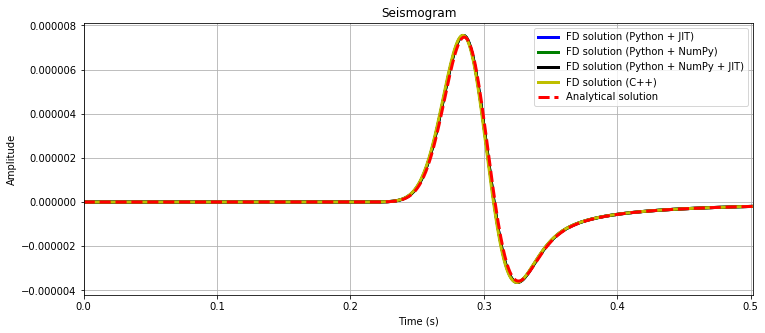

In [29]:
# Compare FD Seismogram with analytical solution
# ----------------------------------------------
# Define figure size
rcParams['figure.figsize'] = 12, 5
plt.plot(time, seis_FD_JIT, 'b-',lw=3,label="FD solution (Python + JIT)") # plot FD seismogram
plt.plot(time, seis_FD_numpy, 'g-',lw=3,label="FD solution (Python + NumPy)") # plot FD seismogram
plt.plot(time, seis_FD_numpy_JIT, 'k-',lw=3,label="FD solution (Python + NumPy + JIT)") # plot FD seismogram
plt.plot(time_Cpp, seis_FD_Cpp, 'y-',lw=3,label="FD solution (C++)") # plot FD seismogram
Analy_seis = plt.plot(time,Gc,'r--',lw=3,label="Analytical solution") # plot analytical solution
plt.xlim(time[0], time[-1])
plt.title('Seismogram')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid()
plt.show()

Finally, we produce some nice bar charts to compare the performance of the different codes developed in this `Jupyter` notebook:

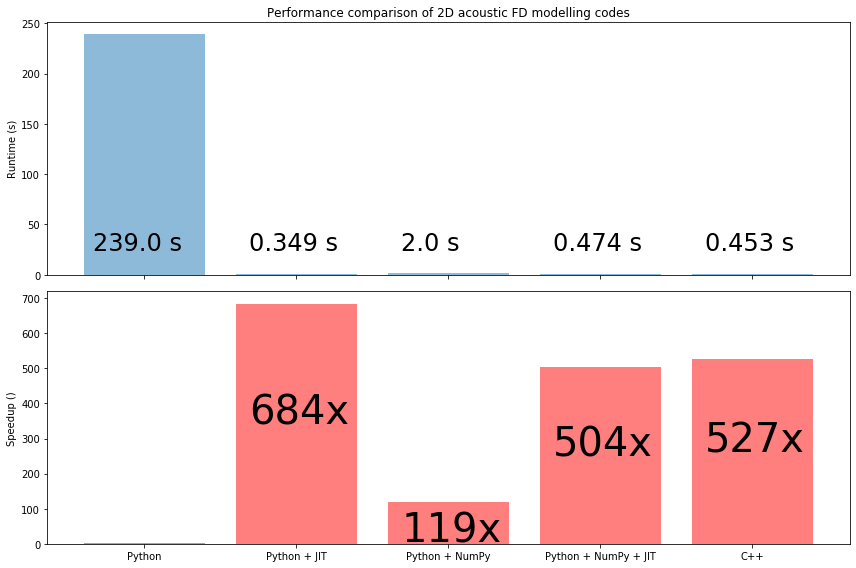

In [22]:
# define codes
codes = ('Python', 'Python + JIT', 'Python + NumPy', 'Python + NumPy + JIT', 'C++')
y_pos = np.arange(len(codes))

# runtime
performance = [t_vanilla_python,t_JIT_python,t_numpy_python,t_numpy_python_JIT,t_cxx]

# speed-up with respect to the non-optimized code
speedup = [t_vanilla_python/t_vanilla_python,
           t_vanilla_python/t_JIT_python,
           t_vanilla_python/t_numpy_python,
           t_vanilla_python/t_numpy_python_JIT,
           t_vanilla_python/t_cxx]

# Define figure size
rcParams['figure.figsize'] = 12, 8

# Plot runtimes of 2D acoustic FD codes
ax1 = plt.subplot(211)

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, codes)
plt.ylabel('Runtime (s)')
plt.title('Performance comparison of 2D acoustic FD modelling codes')

sname = str(np.round(performance[0],decimals=3)) + ' s'
plt.text(y_pos[0]-0.34, performance[0]/10, sname, fontsize=24)

sname = str(np.round(performance[1],decimals=3)) + ' s'
plt.text(y_pos[1]-0.31, performance[0]/10, sname, fontsize=24)

sname = str(np.round(performance[2],decimals=3)) + ' s'
plt.text(y_pos[2]-0.31, performance[0]/10, sname, fontsize=24)

sname = str(np.round(performance[3],decimals=3)) + ' s'
plt.text(y_pos[3]-0.31, performance[0]/10, sname, fontsize=24)

sname = str(np.round(performance[4],decimals=3)) + ' s'
plt.text(y_pos[4]-0.31, performance[0]/10, sname, fontsize=24)
    
# make tick labels invisible
plt.setp(ax1.get_xticklabels(), visible=False)   

# Plot speedup of 2D acoustic FD codes
ax2 = plt.subplot(212, sharex=ax1)    

plt.bar(y_pos, speedup, align='center', alpha=0.5,color='r')
plt.xticks(y_pos, codes)
plt.ylabel('Speedup ()')

sname = str((int)(np.floor(speedup[1]))) + 'x'
plt.text(y_pos[1]-0.31, speedup[1]/2, sname, fontsize=40)

sname = str((int)(np.floor(speedup[2]))) + 'x'
plt.text(y_pos[2]-0.31, speedup[2]/20, sname, fontsize=40)

sname = str((int)(np.floor(speedup[3]))) + 'x'
plt.text(y_pos[3]-0.31, speedup[3]/2, sname, fontsize=40)

sname = str((int)(np.floor(speedup[4]))) + 'x'
plt.text(y_pos[4]-0.31, speedup[4]/2, sname, fontsize=40)

plt.tight_layout()
plt.show()

Is this the best result we can achieve or are further code improvements possible? 

Using domain decomposition with the **Message-Passing Interface MPI** to distribute the workload over multiple CPU cores, combined with a partioning of the tasks in each domain using **Multithreading** can significantly improve the code performance. One key is the manual optimization of CPU and GPU kernels, especially regarding memory access times or communication between MPI processes. As an example I plotted the runtime and speedup for the same homogeneous acoustic problem from this Jupyter notebook using the 2D acoustic modelling code [DENISE Black-Edition](https://github.com/daniel-koehn/DENISE-Black-Edition) which only relies on MPI:

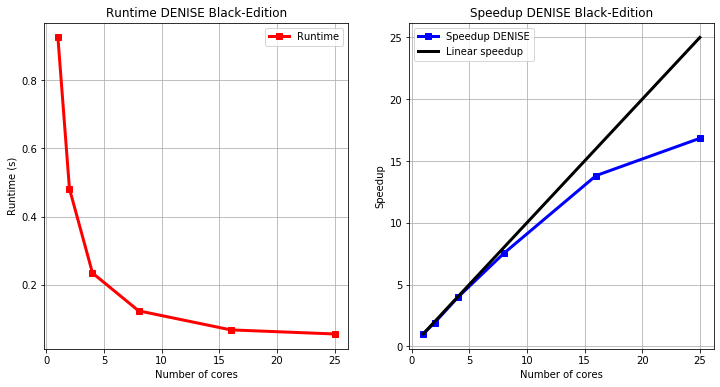

In [23]:
# Define figure size
rcParams['figure.figsize'] = 12, 6

# number of cores and runtime
cores = np.array([1, 2, 4, 8, 16, 25])
t_denise = np.array([0.926, 0.482, 0.234, 0.123, 0.067, 0.055])

# speed-up with respect to the runtime of the 1st core
# and linear speedup
speedup_denise = t_denise[0] / t_denise
linear_speedup = cores

# plot runtime
ax2 = plt.subplot(121)
plt.plot(cores, t_denise, 'rs-',lw=3,label="Runtime")
plt.title('Runtime DENISE Black-Edition')
plt.xlabel('Number of cores')
plt.ylabel('Runtime (s)')
plt.legend()
plt.grid()

# plot speedup
ax2 = plt.subplot(122)
plt.plot(cores, speedup_denise, 'bs-',lw=3,label="Speedup DENISE")
plt.plot(cores, linear_speedup, 'k-',lw=3,label="Linear speedup")
plt.title('Speedup DENISE Black-Edition')
plt.xlabel('Number of cores')
plt.ylabel('Speedup')
plt.legend()
plt.grid()

plt.show() 

Using less than 2 cores, the JIT compiled Python code with a runtime of 353 ms is faster than the MPI code. Utilizing more cores, the DENISE code leads to a steady runtime decrease. However, notice that the speedup is not linear anymore when using 16 cores or more. This can be explained by excessive communication time between the MPI processes, when the domain sizes decreases. More details about MPI and Multithreading optimizations are beyond the scope of the TEW2 course, but will be the topic of a future HPC lecture ...

To get an idea about the difference between JIT optimized Python codes and manually optimized codes, I recommend a SciPy 2016 talk by Andreas Klöckner:

**High Performance with Python: Architectures, Approaches & Applications**

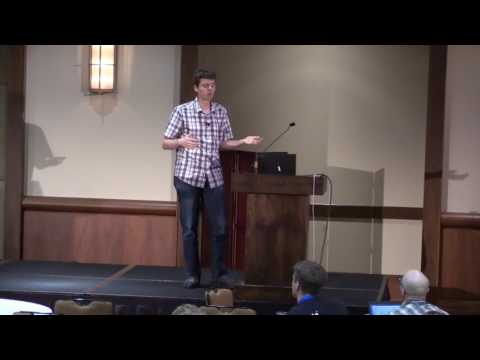

In [24]:
from IPython.display import YouTubeVideo
YouTubeVideo('Zz_6P5qAJck')

##### Bonus Exercise (counts as 2 regular exercises)

Take the JIT optimized 2D acoustic seismic modelling code and use it as a starting point to write a 3D acoustic modelling code. Compare the numerical solution for a 3D homogeneous medium with the analytical solution. Compare the runtime of the 3D code with the 2D code.

##### Bonus-Bonus Exercise (counts as 4.5 regular exercises)

Take the JIT optimized 2D acoustic seismic modelling code and use it as a starting point to write a 4D acoustic modelling code. Compare the seismograms of the numerical solution for the 3D and 4D problem. Compare the runtime of the 4D code with the 2D and 3D codes.

## What we learned:

* The performance of our 2D acoustic FD modelling code, developed in the previous class, suffered from the nested FOR loops
* Using JIT compilation of the Python code using `Numba`, the performance could be significantly improved by a factor 509x
* Alternatively, we can replace the nested FOR loops by `NumPy` array operations to improve the runtime performance
* The performance of the JIT compiled Python code is comparable with a C++ implementation
* Check if the modelling results of your optimized Python codes are still correct